# Amazon Forecast の Get Started サンプル（電力需要予測）を回帰問題としてXGBoostでモデル化する

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/gs-console.html

36時間後までを予測するため、36時間前の情報から予測する必要があります。

## 0.環境準備

In [2]:
import sys
print(sys.path)
sys.path.append('/usr/local/lib/python3.7/site-packages')
print('-------------------------------')
print(sys.path)

['/root/data/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/.sagemakerinternal/conda/lib/python37.zip', '/opt/.sagemakerinternal/conda/lib/python3.7', '/opt/.sagemakerinternal/conda/lib/python3.7/lib-dynload', '', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']
-------------------------------
['/root/data/study-timeseries-analysis/AmazonForecast_vs_XGBoost/notebook', '/opt/.sagemakerinternal/conda/lib/python37.zip', '/opt/.sagemakerinternal/conda/lib/python3.7', '/opt/.sagemakerinternal/conda/lib/python3.7/lib-dynload', '', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages', '/opt/.sagemakerinternal/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.7/site-packages']


In [3]:
pip freeze # condaの環境が出力される？

argcomplete==1.12.3
asn1crypto==0.24.0
async-generator==1.10
attrs==21.2.0
backcall==0.2.0
bleach==4.1.0
certifi==2021.10.8
cffi==1.12.2
chardet==3.0.4
colorama==0.4.4
conda==4.10.3
conda-package-handling==1.7.3
cryptography==2.6.1
debugpy==1.5.0
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
idna==2.8
importlib-metadata==4.8.1
ipykernel==6.4.1
ipython==7.28.0
ipython-genutils==0.2.0
jedi==0.18.0
Jinja2==3.0.2
jsonschema==4.1.0
jupyter-client==6.1.13
jupyter-core==4.8.1
jupyter-kernel-gateway==2.4.0
jupyter-telemetry==0.1.0
jupyterlab-pygments==0.1.2
MarkupSafe==2.0.1
matplotlib-inline==0.1.3
mistune==0.8.4
nb-conda-kernels==2.3.1
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.0.3
packaging==21.0
pandocfilters==1.5.0
parso==0.8.2
pexpect==4.8.0
pickleshare==0.7.5
prometheus-client==0.11.0
prompt-toolkit==3.0.20
psutil==5.8.0
ptyprocess==0.7.0
pycosat==0.6.3
pycparser==2.19
Pygments==2.10.0
pyOpenSSL==19.0.0
pyparsing==2.4.7
pyrsistent==0.18.0
PySo

In [4]:
!pip freeze # コンテナの環境が出力される

ansiwrap==0.8.4
argcomplete==1.12.3
argon2-cffi==21.1.0
attrs==21.2.0
backcall==0.2.0
black==21.9b0
bleach==4.1.0
boto3==1.19.2
botocore==1.22.2
certifi==2021.10.8
cffi==1.15.0
charset-normalizer==2.0.7
click==8.0.3
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
idna==3.3
importlib-metadata==4.8.1
ipykernel==6.4.2
ipython==7.28.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.0
Jinja2==3.0.2
jmespath==0.10.0
joblib==1.1.0
jsonschema==4.1.2
jupyter==1.0.0
jupyter-client==7.0.6
jupyter-console==6.4.0
jupyter-core==4.8.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
kiwisolver==1.3.2
lightgbm==3.3.0
MarkupSafe==2.0.1
matplotlib==3.4.3
matplotlib-inline==0.1.3
mistune==0.8.4
mypy-extensions==0.4.3
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.4.5
nteract-scrapbook==0.4.2
numpy==1.21.3
packaging==21.0
pandas==1.3.4
pandocfilters==1.5.0
papermill==2.3.3
parso==0.8.2
pathspec==0.9.0
pexpect==4.8.0
pickleshare==

## 1.データセット読み込み

In [5]:
import pandas as pd

In [6]:
#df = pd.read_csv('./electricityusage_20140101_20140630.csv', names=['date','demand','item_id'])
df = pd.read_csv('../input/electricityusagedata.zip', names=['date','demand','item_id'])

In [7]:
print(df.shape)
print(df['date'].min())
print(df['date'].max())
df.head()

(3241200, 3)
2014-01-01 01:00:00
2015-01-01 00:00:00


,date,demand,item_id
0,2014-01-01 01:00:00,2.538071,client_0
1,2014-01-01 01:00:00,23.648649,client_1
2,2014-01-01 01:00:00,0.000000,client_2
3,2014-01-01 01:00:00,144.817073,client_3
4,2014-01-01 01:00:00,75.000000,client_4


In [8]:
df['item_id'] = df['item_id'].str.replace('client_','').astype(int)

## 2.特徴量生成

### 1)時刻型に変換し、特徴量（時間帯、曜日）を抽出

In [9]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

In [10]:
df['num_of_week'] = df['date'].dt.dayofweek

In [11]:
df['hour'] = df['date'].dt.hour

### 2)clientごとに時間差の値を特徴量にもつ（36hより前である必要がある）

In [12]:
df["before_36h"] = df.groupby(['item_id']).shift(36)['demand'].reset_index()['demand']
df["before_37h"] = df.groupby(['item_id']).shift(37)['demand'].reset_index()['demand']
df["before_38h"] = df.groupby(['item_id']).shift(38)['demand'].reset_index()['demand']
df["before_48h"] = df.groupby(['item_id']).shift(48)['demand'].reset_index()['demand']
df["before_72h"] = df.groupby(['item_id']).shift(72)['demand'].reset_index()['demand']
df["before_96h"] = df.groupby(['item_id']).shift(96)['demand'].reset_index()['demand']

### 3)clientごとに期間で集約する

In [13]:
df = df.sort_values(["item_id","date"]).reset_index()
df['mean_24h'] = df.groupby(['item_id']).rolling(24)['demand'].mean().reset_index()['demand']
df['var_24h'] = df.groupby(['item_id']).rolling(24)['demand'].var().reset_index()['demand']

In [14]:
#df = df.sort_values(["client","timestamp"]).reset_index()
#df['mean_24h_before_36h'] = df.groupby(['client']).rolling(2)['demand'].mean().reset_index()['demand']

In [15]:
df["mean_24h_before_36h"] = df.groupby(['item_id']).shift(36)['mean_24h'].reset_index()['mean_24h']
df["var_24h_before_36h"] = df.groupby(['item_id']).shift(36)['var_24h'].reset_index()['var_24h']

In [16]:
df[df.item_id==21].head()

,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
183960,21,2014-01-01 01:00:00,29.887920,21,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183961,391,2014-01-01 02:00:00,28.953923,21,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183962,761,2014-01-01 03:00:00,28.953923,21,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183963,1131,2014-01-01 04:00:00,25.373599,21,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183964,1501,2014-01-01 05:00:00,23.661270,21,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df[df.item_id==21].tail()

,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
192715,3239371,2014-12-31 20:00:00,43.586550,21,2,20,28.798257,25.062267,25.996264,53.237858,42.029888,45.143213,25.289280,47.597890,36.795610,94.835153
192716,3239741,2014-12-31 21:00:00,40.317559,21,2,21,45.143213,28.798257,25.062267,47.478207,42.808219,40.940224,25.451432,51.997619,37.042082,97.544219
192717,3240111,2014-12-31 22:00:00,36.581569,21,2,22,51.992528,45.143213,28.798257,36.581569,41.718555,36.737235,25.658987,55.694928,37.113429,99.637520
192718,3240481,2014-12-31 23:00:00,32.222914,21,2,23,52.148194,51.992528,45.143213,32.222914,33.156912,36.892902,25.886000,57.460307,37.450706,107.252683
192719,3240851,2015-01-01 00:00:00,33.935243,21,3,0,45.765878,52.148194,51.992528,33.623910,30.666252,33.468244,26.184361,60.150056,37.353414,105.317417


In [18]:
feature_col = [
    'item_id',
    'num_of_week',
    'hour',
    'before_36h',
    'before_37h',
    'before_38h',
    'before_48h',
    'before_72h',
    'before_96h',
    'mean_24h_before_36h',
    'var_24h_before_36h'
]

## 3.データ分割
all:2014-01-01 01:00:00 〜 2015-01-01 00:00:00  
train:2014-01-01 01:00:00 〜 2014-12-29 00:00:00  
valid:2014-12-29 01:00:00 〜 2014-12-30 12:00:00(36h)  
test:2014-12-30 13:00:00 〜 2015-01-01 00:00:00(36h)  

In [19]:
#df_train = df[df.timestamp <= '2014-12-29 00:00:00']
df_train = df[df.date < '2014-06-29 00:00:00']

In [20]:
df_train.tail()

,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
3236730,1587669,2014-06-28 19:00:00,20243.243243,369,5,19,18824.324324,21270.270270,19608.108108,27337.837838,22378.378378,21851.351351,20557.432432,1.887037e+06,21716.216216,6.252469e+06
3236731,1588039,2014-06-28 20:00:00,19243.243243,369,5,20,22783.783784,18824.324324,21270.270270,24635.135135,19783.783784,23891.891892,20396.396396,1.652200e+06,21850.225225,6.082557e+06
3236732,1588409,2014-06-28 21:00:00,18864.864865,369,5,21,19959.459459,22783.783784,18824.324324,25310.810811,22594.594595,19608.108108,20212.274775,1.356329e+06,21948.198198,5.445560e+06
3236733,1588779,2014-06-28 22:00:00,18635.135135,369,5,22,19513.513514,19959.459459,22783.783784,22445.945946,22581.081081,17864.864865,20084.459459,1.350847e+06,21912.725225,5.592975e+06
3236734,1589149,2014-06-28 23:00:00,19175.675676,369,5,23,20567.567568,19513.513514,19959.459459,22729.729730,21364.864865,20054.054054,20042.792793,1.384582e+06,21992.117117,5.205671e+06


In [21]:
df_valid = df[(df.date >= '2014-06-29 00:00:00') & (df.date < '2014-07-01 00:00:00')]

In [22]:
print(df_valid.shape)
df_valid.head()

(17760, 16)


,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
4295,1589150,2014-06-29 00:00:00,1.269036,0,6,0,1.903553,1.903553,0.317259,1.586294,1.586294,1.903553,0.793147,0.245069,1.348350,0.474821
4296,1589520,2014-06-29 01:00:00,1.269036,0,6,1,1.586294,1.903553,1.903553,1.269036,1.269036,1.586294,0.779928,0.227381,1.335131,0.463698
4297,1589890,2014-06-29 02:00:00,1.269036,0,6,2,0.634518,1.586294,1.903553,1.586294,1.269036,1.903553,0.766709,0.209329,1.308693,0.484120
4298,1590260,2014-06-29 03:00:00,1.269036,0,6,3,2.220812,0.634518,1.586294,1.586294,1.269036,1.903553,0.766709,0.209329,1.282255,0.415559
4299,1590630,2014-06-29 04:00:00,1.269036,0,6,4,3.172589,2.220812,0.634518,1.586294,1.269036,1.903553,0.766709,0.209329,1.295474,0.463151


In [23]:
df_valid.tail()

,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
3236778,1605429,2014-06-30 19:00:00,20540.540541,369,0,19,18337.837838,18500.000000,18635.135135,20243.243243,26081.081081,27337.837838,18716.216216,1.290294e+06,19310.247748,1.229086e+06
3236779,1605799,2014-06-30 20:00:00,18972.972973,369,0,20,18459.459459,18337.837838,18500.000000,19243.243243,23108.108108,24635.135135,18672.297297,1.216443e+06,19249.436937,1.240591e+06
3236780,1606169,2014-06-30 21:00:00,21432.432432,369,0,21,17756.756757,18459.459459,18337.837838,18864.864865,23283.783784,25310.810811,18737.049550,1.480055e+06,19157.657658,1.306756e+06
3236781,1606539,2014-06-30 22:00:00,20540.540541,369,0,22,19729.729730,17756.756757,18459.459459,18635.135135,21702.702703,22445.945946,18769.144144,1.573982e+06,19077.702703,1.044530e+06
3236782,1606909,2014-06-30 23:00:00,23013.513514,369,0,23,21810.810811,19729.729730,17756.756757,19175.675676,20175.675676,22729.729730,18938.063063,2.325879e+06,19122.747748,1.248530e+06


In [24]:
df_test = df[(df.date >= '2014-07-01 00:00:00') & (df.date < '2014-07-03 00:00:00')]

In [25]:
print(df_test.shape)
df_test.head()

(17760, 16)


,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
4343,1606910,2014-07-01 00:00:00,1.586294,0,1,0,0.317259,0.634518,0.634518,1.269036,1.269036,1.586294,1.097187,0.507460,0.753490,0.182160
4344,1607280,2014-07-01 01:00:00,1.586294,0,1,1,0.317259,0.317259,0.634518,1.269036,1.586294,1.269036,1.110406,0.516395,0.740271,0.189636
4345,1607650,2014-07-01 02:00:00,1.586294,0,1,2,0.634518,0.317259,0.317259,1.269036,1.586294,1.586294,1.136844,0.524418,0.753490,0.182160
4346,1608020,2014-07-01 03:00:00,1.586294,0,1,3,0.317259,0.634518,0.317259,1.269036,1.269036,1.586294,1.136844,0.524418,0.753490,0.182160
4347,1608390,2014-07-01 04:00:00,1.903553,0,1,4,0.317259,0.317259,0.634518,1.269036,1.269036,1.586294,1.176502,0.546846,0.740271,0.189636


In [26]:
df_test.tail()

,index,date,demand,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h,var_24h,mean_24h_before_36h,var_24h_before_36h
3236826,1623189,2014-07-02 19:00:00,24581.081081,369,2,19,19472.972973,22675.675676,19675.675676,20540.540541,20675.675676,20243.243243,21911.599099,1.716708e+06,19837.274775,3.390947e+06
3236827,1623559,2014-07-02 20:00:00,21513.513514,369,2,20,20067.567568,19472.972973,22675.675676,18972.972973,20027.027027,19243.243243,21783.220721,1.393424e+06,19951.013514,3.108137e+06
3236828,1623929,2014-07-02 21:00:00,23608.108108,369,2,21,19054.054054,20067.567568,19472.972973,21432.432432,19878.378378,18864.864865,21802.927928,1.458347e+06,20057.995495,2.609307e+06
3236829,1624299,2014-07-02 22:00:00,23851.351351,369,2,22,19756.756757,19054.054054,20067.567568,20540.540541,19770.270270,18635.135135,21807.432432,1.477074e+06,20079.391892,2.583913e+06
3236830,1624669,2014-07-02 23:00:00,22608.108108,369,2,23,19797.297297,19756.756757,19054.054054,23013.513514,18959.459459,19175.675676,21812.500000,1.484872e+06,20198.761261,2.141923e+06


In [27]:
df_train[df_train.item_id==21].shape

(4295, 16)

In [28]:
df_valid[df_valid.item_id==21].shape

(48, 16)

In [29]:
df_test[df_test.item_id==21].shape

(48, 16)

In [30]:
tr_x = df_train[feature_col]
tr_y = df_train['demand']

In [31]:
va_x = df_valid[feature_col]
va_y = df_valid['demand']

In [32]:
test_x = df_test[feature_col]
test_y = df_test[['date','item_id','demand']]

In [33]:
import xgboost as xgb

In [34]:
dtrain = xgb.DMatrix(tr_x, label=tr_y)
dvalid = xgb.DMatrix(va_x, label=va_y)
dtest = xgb.DMatrix(test_x)

## 4.モデル学習
誤差はRMSEを用いる

https://docs.aws.amazon.com/ja_jp/forecast/latest/dg/metrics.html

In [35]:
import xgboost as xgb

In [56]:
from sklearn.metrics import mean_squared_error

In [58]:
# 学習時fitパラメータ指定
fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'early_stopping_rounds': 10,  # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              }

In [59]:
# 乱数シード
seed = 42
#fit by best params
regressor = xgb.XGBRegressor(booster='gbtree',
                             objective='reg:squarederror',
                             random_state=seed,
                             n_estimators=10000)

In [60]:
regressor.fit(tr_x,
              tr_y,
              eval_metric="rmse",
              eval_set=[(va_x, va_y)],
              early_stopping_rounds=50)

[0]	validation_0-rmse:2683.56030
[1]	validation_0-rmse:1810.78186
[2]	validation_0-rmse:1190.81689
[3]	validation_0-rmse:770.05621
[4]	validation_0-rmse:591.09393
[5]	validation_0-rmse:536.71435
[6]	validation_0-rmse:545.23602
[7]	validation_0-rmse:606.04694
[8]	validation_0-rmse:675.36090
[9]	validation_0-rmse:697.34235
[10]	validation_0-rmse:717.92920
[11]	validation_0-rmse:749.67401
[12]	validation_0-rmse:759.66009
[13]	validation_0-rmse:759.63837
[14]	validation_0-rmse:781.49438
[15]	validation_0-rmse:790.96210
[16]	validation_0-rmse:791.57074
[17]	validation_0-rmse:799.18085
[18]	validation_0-rmse:794.32666
[19]	validation_0-rmse:798.97882
[20]	validation_0-rmse:800.90350
[21]	validation_0-rmse:802.29273
[22]	validation_0-rmse:802.07281
[23]	validation_0-rmse:802.90301
[24]	validation_0-rmse:797.91370
[25]	validation_0-rmse:795.79797
[26]	validation_0-rmse:802.63544
[27]	validation_0-rmse:804.46588
[28]	validation_0-rmse:806.24164
[29]	validation_0-rmse:811.69794
[30]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 5.モデル評価

### testデータでのRMSE

In [61]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [62]:
test_y

,date,item_id,demand
4343,2014-07-01 00:00:00,0,1.586294
4344,2014-07-01 01:00:00,0,1.586294
4345,2014-07-01 02:00:00,0,1.586294
4346,2014-07-01 03:00:00,0,1.586294
4347,2014-07-01 04:00:00,0,1.903553
...,...,...,...
3236826,2014-07-02 19:00:00,369,24581.081081
3236827,2014-07-02 20:00:00,369,21513.513514
3236828,2014-07-02 21:00:00,369,23608.108108
3236829,2014-07-02 22:00:00,369,23851.351351


In [63]:
### RMSEを出力
np.sqrt(mean_squared_error(test_y['demand'], regressor.predict(test_x)))

568.4094118115607

### 重要度の可視化

In [64]:
!pip install matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

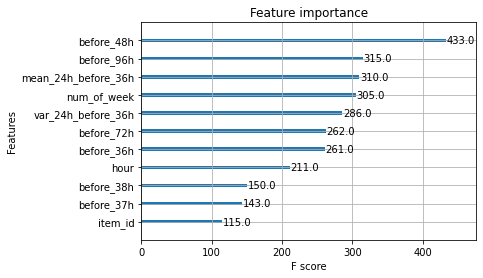

In [65]:
xgb.plot_importance(regressor)

## 6.推論（予測）
https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py

In [66]:
regressor.predict(test_x)

array([   26.713282,    26.713282,    26.713282, ..., 17771.207   ,
       17587.254   , 17852.092   ], dtype=float32)

In [67]:
test_x

,item_id,num_of_week,hour,before_36h,before_37h,before_38h,before_48h,before_72h,before_96h,mean_24h_before_36h,var_24h_before_36h
4343,0,1,0,0.317259,0.634518,0.634518,1.269036,1.269036,1.586294,0.753490,1.821604e-01
4344,0,1,1,0.317259,0.317259,0.634518,1.269036,1.586294,1.269036,0.740271,1.896365e-01
4345,0,1,2,0.634518,0.317259,0.317259,1.269036,1.586294,1.586294,0.753490,1.821604e-01
4346,0,1,3,0.317259,0.634518,0.317259,1.269036,1.269036,1.586294,0.753490,1.821604e-01
4347,0,1,4,0.317259,0.317259,0.634518,1.269036,1.269036,1.586294,0.740271,1.896365e-01
...,...,...,...,...,...,...,...,...,...,...,...
3236826,369,2,19,19472.972973,22675.675676,19675.675676,20540.540541,20675.675676,20243.243243,19837.274775,3.390947e+06
3236827,369,2,20,20067.567568,19472.972973,22675.675676,18972.972973,20027.027027,19243.243243,19951.013514,3.108137e+06
3236828,369,2,21,19054.054054,20067.567568,19472.972973,21432.432432,19878.378378,18864.864865,20057.995495,2.609307e+06
3236829,369,2,22,19756.756757,19054.054054,20067.567568,20540.540541,19770.270270,18635.135135,20079.391892,2.583913e+06


## 7.推論結果の可視化
client_21について  
正解データ  
Amazon Foreast  
xgboost  

In [68]:
df_xgb = pd.DataFrame(regressor.predict(test_x[test_x.item_id==21]), columns=['xgb'])

In [69]:
df_xgb

,xgb
0,26.713282
1,26.713282
2,26.713282
3,26.713282
4,26.713282
5,26.713282
6,26.713282
7,26.713282
8,26.713282
9,34.731277


In [70]:
df_y = pd.DataFrame(test_y[test_y.item_id==21]['demand'], columns=['demand']).reset_index(drop=True)

In [71]:
df_y

,demand
0,21.481943
1,19.302615
2,16.656289
3,16.033624
4,15.566625
5,16.344956
6,11.674969
7,11.052304
8,19.146949
9,45.143213


### Foreastの結果

In [72]:
df0 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part0.csv')
df1 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part1.csv')
df2 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part2.csv')
df3 = pd.read_csv('../export_forecast_numbacktest_1/export_model1_20140701_20140702_2021-11-05T00-51-05Z_part3.csv')

In [73]:
df_forecast = pd.concat([df0,df1,df2,df3])

In [74]:
df_forecast['item_id'].unique()

array(['client_224', 'client_233', 'client_111', 'client_69',
       'client_121', 'client_150', 'client_335', 'client_65', 'client_40',
       'client_337', 'client_246', 'client_262', 'client_185',
       'client_229', 'client_256', 'client_348', 'client_135',
       'client_153', 'client_106', 'client_183', 'client_71',
       'client_319', 'client_101', 'client_286', 'client_132',
       'client_28', 'client_204', 'client_213', 'client_291',
       'client_343', 'client_311', 'client_225', 'client_178',
       'client_333', 'client_37', 'client_221', 'client_85', 'client_270',
       'client_126', 'client_164', 'client_125', 'client_304',
       'client_139', 'client_321', 'client_196', 'client_72', 'client_3',
       'client_52', 'client_352', 'client_48', 'client_331', 'client_60',
       'client_355', 'client_293', 'client_5', 'client_152', 'client_330',
       'client_217', 'client_296', 'client_245', 'client_341',
       'client_143', 'client_117', 'client_198', 'client_104',


In [75]:
df_result = df_forecast[df_forecast.item_id=='client_21'].reset_index(drop=True)

In [76]:
df_result

,item_id,date,p10,p50,p90
0,client_21,2014-07-01T00:00:00Z,19.166048,21.778353,23.937222
1,client_21,2014-07-01T01:00:00Z,16.131132,18.307056,20.588642
2,client_21,2014-07-01T02:00:00Z,14.010031,15.778008,17.750347
3,client_21,2014-07-01T03:00:00Z,13.835012,15.893695,17.614340
4,client_21,2014-07-01T04:00:00Z,13.765792,15.686901,17.802788
5,client_21,2014-07-01T05:00:00Z,14.773319,16.603321,19.548822
6,client_21,2014-07-01T06:00:00Z,10.852861,12.444874,14.222213
7,client_21,2014-07-01T07:00:00Z,7.900496,9.689272,11.803659
8,client_21,2014-07-01T08:00:00Z,14.899228,16.662745,18.136972
9,client_21,2014-07-01T09:00:00Z,28.941788,33.086403,37.724083


<AxesSubplot:xlabel='date'>

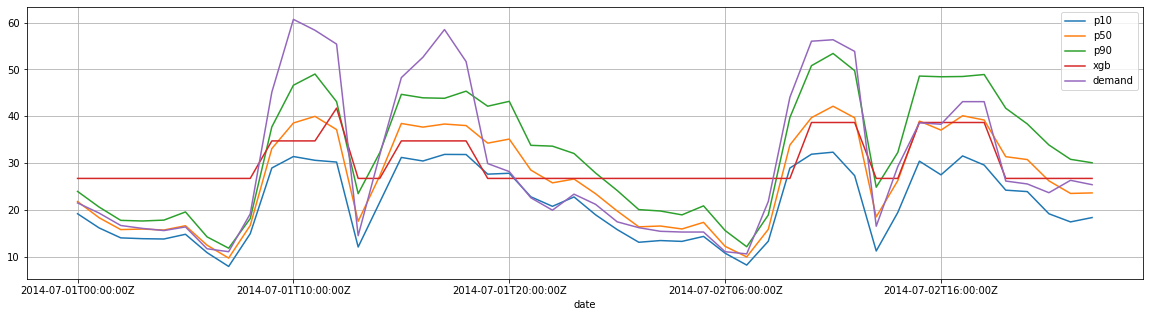

In [77]:
pd.concat([df_result, df_xgb, df_y], axis=1).plot(x='date',figsize=(20,5), grid=True)

# XGBoostの利点
特徴量の重要度がわかる

【デメリット】
コードのデバッグが大変
特徴量を作り込む必要あり
ハイパーパラメータのチューニング
